# Example 04. Develop a voxel-based model of $P_{gap}$

This example builds a voxel-based model of directional gap probability, $P_{gap}$($\theta$), using multiple scan positions. The model is still currently in development and may produce unintended results.

## Load all the required modules

In [1]:
import os
import json
import glob
import numpy as np
import rasterio as rio

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
from matplotlib import animation, rc

from IPython.display import HTML

from pylidar_canopy import voxelization, riegl_io

## Some plotting functions

In [2]:
def initfig(fig, axes, src, layer, vmin_vals, vmax_vals, bounds, voxelsize, titles, nodata=-9999):
    elev = bounds[2] + (layer - 1) * voxelsize
    fig.suptitle(f'Elevation {elev:.1f} m', fontsize=16)
    images = []    
    with plt.style.context('seaborn-notebook'):    
        for i,ax in enumerate(axes):
            tmp = np.ma.masked_equal(src[i].read(layer), nodata)
            im = ax.imshow(tmp, cmap='gist_gray', animated=True, 
                           vmin=vmin_vals[i], vmax=vmax_vals[i])        
            xt = ax.get_xticks().tolist()
            yt = ax.get_yticks().tolist()
            t = [src[i].transform * c for c in zip(xt,yt)]
            ax.xaxis.set_major_locator(mticker.FixedLocator(xt))
            ax.set_xticklabels([f'{c[0]:.1f}' for c in t])
            ax.yaxis.set_major_locator(mticker.FixedLocator(yt))
            ax.set_yticklabels([f'{c[1]:.1f}' for c in t])
            ax.set_title(titles[i])
            ax.set_facecolor('lightyellow')
            images.append(im)   
    return images    
    
def updatefig(*args, nodata=-9999):
    global layer
    elev = bounds[2] + (layer - 1) * voxelsize
    fig.suptitle(f'Elevation {elev:.1f} m', fontsize=16)
    for i,im in enumerate(images):
        tmp = np.ma.masked_equal(src[i].read(layer), nodata)
        im.set_array(tmp)
    layer += 1
    return images

def plot_voxel_grid(data, title=['Range (m)'], clim=[[0,30]], figsize=(16,10), nbins=[10],
                    cmap=['bone'], extend=['max'], nodata=-9999, extent=None,
                    xlabel=None, ylabel=None, facecolor='white', suptitle=None):
    """Example function to plot a voxel grid"""
    ngrids = len(data)
    fig, ax = plt.subplots(ncols=ngrids, nrows=1, squeeze=True, 
                           sharex=True, sharey=True, figsize=figsize)
    fig.suptitle(suptitle, fontsize=16)
    with plt.style.context('seaborn-notebook'):
        for i in range(ngrids):  
            ax[i].set_facecolor(facecolor)
            ax[i].set(adjustable='box', aspect='equal')
            ax[i].set(xlabel=xlabel, ylabel=ylabel, title=title[i])
            if extent is None:
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i].imshow(tmp, interpolation='nearest', clim=clim[i], 
                             cmap=matplotlib.cm.get_cmap(cmap[i],nbins[i]),  
                             vmin=clim[i][0], vmax=clim[i][1], extent=extent)
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, cax=cax, extend=extend[i])
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=nbins[i]))
    fig.tight_layout()
    plt.show()

## Identify all of the input files

We need both the RDBX and RXP files for the VZ400i and later scanner models. The RDBX have the point cloud corrected with RIEGL MTA processing, and the RXP files have all the pulse information for shots with not returns, allowing us to separate the absence of a return from the absence of a measurement.

If you are using a RIEGL VZ400 scanner or used a pulse rate <= 300khz, then you only need the RXP files.

In [3]:
# RiScanPro project directory
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/neon_serc_220305_024625.RiSCAN')

# Get the list of input files
rxp_fn = []
rdbx_fn = []
transform_fn = []
for d in os.listdir('SCANS'):
    if os.path.isdir(f'SCANS/{d}') and d.startswith('ScanPos'):
        
        # RXP
        fpath = f'SCANS/{d}/SINGLESCANS/??????_??????.rxp'
        flist = glob.glob(fpath)
        fn = max(flist, key=os.path.getctime)
        rxp_fn.append(fn)
        
        # RDBX
        prefix,suffix = os.path.splitext(fn)
        scan = os.path.basename(prefix)
        fn = f'project.rdb/SCANS/{d}/SINGLESCANS/{scan}/{scan}.rdbx'
        rdbx_fn.append(fn)
        
        # Transform
        fn = f'SCANS/matrix/{d}.DAT'
        transform_fn.append(fn)

# DTM (at present these need to be generated independently, in the same local coordinate system as the TLS data)
local_dtm = '/gpfs/data1/vclgp/data/tls_point_clouds/dtms/neon_serc_220305_024625/local.tif'

## Process a single scan on a defined voxel grid

In [4]:
vgrid = voxelization.VoxelGrid(dtm_filename=local_dtm)

In [5]:
# set rdbx_file to None if only the RXP file is needed
vgrid.add_riegl_scan_position(rxp_fn[-1], transform_fn[-1], 
                              rdbx_file=None, chunk_size=10000000)

In [6]:
bounds = [-25,-25,-15,25,25,45]
voxelsize = 1.0

vgrid.voxelize_scan(bounds, voxelsize, save_counts=True)

In [7]:
prefix,suffix = os.path.splitext(rxp_fn[0])
scan = os.path.basename(prefix)
prefix = f'/gpfs/data1/vclgp/armstonj/tls_temp/{scan}'
vgrid.write_grids(prefix)

## Visualize the single scan voxel outputs

In [8]:
fig,axes = plt.subplots(figsize=[15,4], ncols=3, nrows=1, squeeze=True)

names = ['hits','miss','occl']
src = [rio.open(vgrid.filenames[k]) for k in sorted(vgrid.filenames) if k in names]
vmin_vals = [0,0,0]
vmax_vals = [1000,10000,10000]
titles = ['Hit','Miss','Occluded']

layer = 1
images = initfig(fig, axes, src, layer, vmin_vals, vmax_vals, bounds, voxelsize, titles)
anim = animation.FuncAnimation(fig, updatefig, interval=50, blit=True, frames=57)
plt.close()

HTML(anim.to_jshtml())

In [9]:
fig,axes = plt.subplots(figsize=[18,4], ncols=4, nrows=1, squeeze=True)

names = ['pgap','vcls','vwts','zeni']
src = [rio.open(vgrid.filenames[k]) for k in sorted(vgrid.filenames) if k in names]
vmin_vals = [0,1,0,0]
vmax_vals = [1,5,1,np.pi]
titles = [r'$P_{gap}$','Class','Weights','Zenith']

layer = 1
images = initfig(fig, axes, src, layer, vmin_vals, vmax_vals, bounds, voxelsize, titles)
anim = animation.FuncAnimation(fig, updatefig, interval=50, blit=True, frames=57)
plt.close()

HTML(anim.to_jshtml())

In [10]:
names = ['pgap','vcls','vwts','zeni']
z = 20
elev = bounds[2] + z * voxelsize

src = [rio.open(vgrid.filenames[k]) for k in sorted(vgrid.filenames) if k in names]
data_s = [s.read(z+1) for s in src]

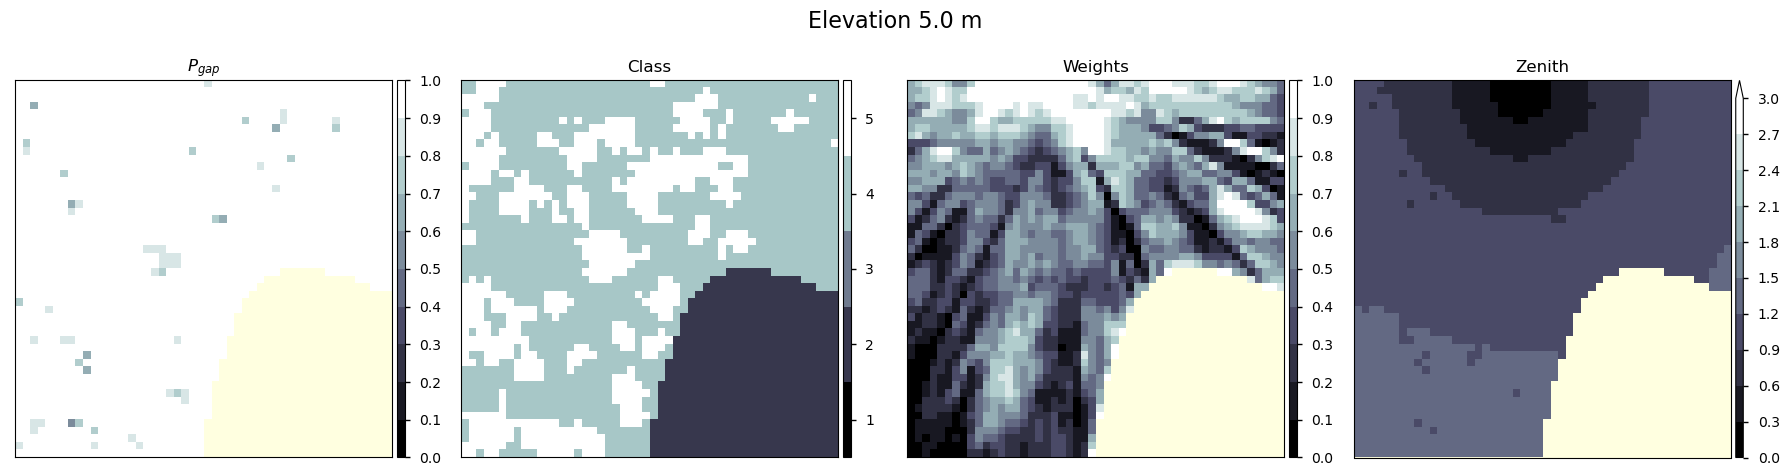

In [11]:
clim = [[0,1],[0.5,5.5],[0,1],[0,3]]
nbins = [10,5,10,10]
title = [r'$P_{gap}$','Class','Weights','Zenith']
extend = ['neither','neither','neither','max']
cmap = ['bone','bone','bone','bone']

plot_voxel_grid(data_s, title=title, clim=clim, figsize=(18,5), nbins=nbins,
                cmap=cmap, extend=extend, nodata=-9999, extent=None,
                xlabel=None, ylabel=None, facecolor='lightyellow', 
                suptitle=f'Elevation {elev:.1f} m')

## Process each scan on the voxel grid

In [12]:
bounds = [-25,-25,-15,25,25,45]
voxelsize = 1.0

config = {}
config['bounds'] = bounds
config['resolution'] = voxelsize
config['nx'] = int( (bounds[3] - bounds[0]) // voxelsize)
config['ny'] = int( (bounds[4] - bounds[1]) // voxelsize)
config['nz'] = int( (bounds[5] - bounds[2]) // voxelsize)
config['nodata'] = -9999
config['positions'] = {}

In [13]:
%%time

npos = len(rxp_fn)
for i in range(npos):
    fn = os.path.basename(rxp_fn[i]) 
    name = os.path.splitext(fn)[0]
    vgrid_i = voxelization.VoxelGrid(dtm_filename=local_dtm)
    vgrid_i.add_riegl_scan_position(rxp_fn[i], transform_fn[i], 
                                    rdbx_file=None, chunk_size=10000000)
    vgrid_i.voxelize_scan(bounds, voxelsize, save_counts=True)
    prefix = f'/gpfs/data1/vclgp/armstonj/tls_temp/{name}'
    vgrid_i.write_grids(prefix)
    config['positions'][name] = vgrid_i.filenames

CPU times: user 9min 39s, sys: 1min 41s, total: 11min 21s
Wall time: 11min 21s


In [14]:
config_fn = '/gpfs/data1/vclgp/armstonj/tls_temp/neon_serc_220305_024625_config.json'

In [15]:
with open(config_fn, 'w') as f:
    tmp = json.dumps(config, indent=4)
    f.write(tmp)

## Derive PAI and the vertical canopy cover profile

In [16]:
vmodel = voxelization.VoxelModel(config_fn)
paiv,paih,nscans = vmodel.run_linear_model(min_n=3, weights=False)
cover_z = vmodel.get_cover_profile(paiv)

## Visualize the multiple scan voxel outputs

In [17]:
z = 25
elev = vmodel.bounds[2] + z * vmodel.resolution

paiv = np.ma.masked_equal(paiv, vmodel.nodata)
paih = np.ma.masked_equal(paih, vmodel.nodata)
nscans = np.ma.masked_equal(nscans, vmodel.nodata)

data_m = [paiv.mean(axis=0),
          paih.mean(axis=0),
          nscans[z],
          cover_z.max(axis=0)]

In [ ]:
clim = [[0,0.1],[0,0.1],[-0.5,8.5],[0,1]]
nbins = [10,10,9,10]
title = [r'$PAI_{v}$',
         r'$PAI_{h}$',
         f'Number of Scans (z={elev:.1f}m)',
         'Canopy Cover']
extend = ['max','max','neither','neither']
cmap = ['bone','bone','bone','bone']

plot_voxel_grid(data_m, title=title, clim=clim, figsize=(18,5), nbins=nbins,
                cmap=cmap, extend=extend, nodata=vmodel.nodata, extent=None,
                xlabel=None, ylabel=None, facecolor='lightyellow', 
                suptitle='neon_serc_220305_024625')